# Random Forest Implementation

In [1]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def change_df(df):
    new_df = df.loc[:, ['name_file_1', 'code_java_1', 'name_file_2', 'code_java_2', 'label']]
    
    new_df = new_df.rename(columns={'code_java_1': 'java_code_1', 'code_java_2': 'java_code_2', 'label': 'verdict'})

    return new_df

In [3]:
def balance_data(df):
    new_df = pd.concat([df[df['verdict'] == 1], df[df['verdict'] == 0].head(400)], ignore_index=True)

    return new_df

In [4]:
# Recopila data de los csv
def get_data(no_plagio, plagio, non_plagiarized, plagiarized):
    data1 = pd.read_csv(no_plagio)
    data2 = pd.read_csv(plagio)
    data3 = pd.read_csv(non_plagiarized)
    data4 = pd.read_csv(plagiarized)
    
    conplag = pd.concat([data3, data4], ignore_index=True)
    fire = pd.concat([data1, data2], ignore_index=True)
    conplag = change_df(conplag)

    data = pd.concat([fire, conplag], ignore_index=True)
    return data

In [5]:
# Devuelve los codigos
def get_features(data):
    features = data[['java_code_1', 'java_code_2']]
    return features

In [6]:
# Devuelve los labels (Plagio = 1, No Plagio = 0)
def get_labels(data):
    labels = data[['verdict']]
    return labels

In [7]:
# Convierte los codigos en secuencias de enteros para que puedan ser procesados
def tokenizar(features_train, features_test):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(features_train['java_code_1'] + features_train['java_code_2'])
    features_train_sequences_code1 = tokenizer.texts_to_sequences(features_train['java_code_1'])
    features_train_sequences_code2 = tokenizer.texts_to_sequences(features_train['java_code_2'])
    features_test_sequences_code1 = tokenizer.texts_to_sequences(features_test['java_code_1'])
    features_test_sequences_code2 = tokenizer.texts_to_sequences(features_test['java_code_2'])
    return features_train_sequences_code1, features_train_sequences_code2, features_test_sequences_code1, features_test_sequences_code2

## Preprocesado
 Para que el modelo funcione correctamente debe recibir el mismo input_shape de los codigos de Java. Es por ello que se les aplica un padding para normalizar las secuencias.

In [8]:
# Asegurarse de que todas las secuencias tengan la misma longitud
def padding(train_f1, train_f2, test_f1, test_f2):
    max_train_f1 = max(len(seq) for seq in train_f1) 
    max_train_f2 = max(len(seq) for seq in train_f2)
    max_test_f1 = max(len(seq) for seq in test_f1)
    max_test_f2 = max(len(seq) for seq in test_f2)
    max_length = max(max_train_f1, max_train_f2, max_test_f1, max_test_f2)

    features_train_sequences_code1 = pad_sequences(
        train_f1,
        maxlen = max_length
    )

    features_train_sequences_code2 = pad_sequences(
        train_f2,
        maxlen = max_length
    )

    features_test_sequences_code1 = pad_sequences(
        test_f1,
        maxlen = max_length
    )

    features_test_sequences_code2 = pad_sequences(
        test_f2,
        maxlen = max_length
    )
    print(max_length)

    return features_train_sequences_code1, features_train_sequences_code2, features_test_sequences_code1, features_test_sequences_code2

In [9]:
data = get_data(
    'codigos_no_plagio.csv',
    'codigos_plagio.csv',
    'non_plagiarized_java_pairs/non_plagiarized_java_pairs.csv',
    'plagiarized_java_pairs.csv'
)

In [10]:
data.shape

(48068, 7)

In [11]:
data = balance_data(data)

In [12]:
data.shape

(735, 7)

In [13]:

features = get_features(data)
labels = get_labels(data)

In [14]:
# Split de Train y Test
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [15]:
# Codigos en secuencias de enteros
features_train_sequences_code1, features_train_sequences_code2, features_test_sequences_code1, features_test_sequences_code2 = tokenizar(
    features_train, 
    features_test
)

In [16]:
# Todas las secuencias tengan la misma longitud
features_train_code1, features_train_code2, features_test_code1, features_test_code2 = padding(
    features_train_sequences_code1,
    features_train_sequences_code2,
    features_test_sequences_code1,
    features_test_sequences_code2
)

4646


In [17]:
clasificador = RandomForestClassifier()

In [18]:
features_train_concatenated = np.concatenate(
    (
        features_train_code1,
        features_train_code2
    ), 
    axis = 1
)

clasificador.fit(features_train_concatenated, labels_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [19]:
features_test_concatenated = np.concatenate(
    (
        features_test_code1,
        features_test_code2
    ), 
    axis = 1
)

labels_prediction = clasificador.predict(features_test_concatenated)

Confusion Matrix:
 [[67  8]
 [31 41]]


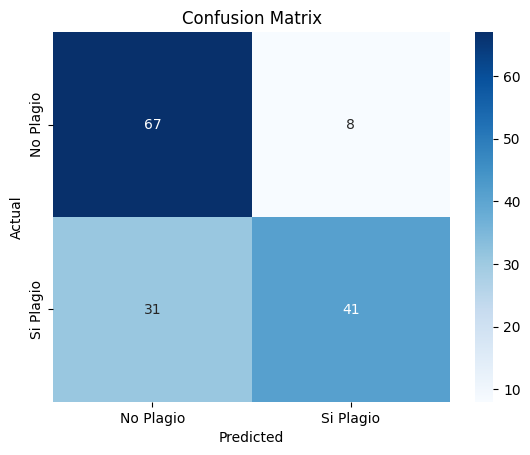

In [20]:
cm = confusion_matrix(labels_test, labels_prediction)
print('Confusion Matrix:\n', cm)

# Assuming cm is the confusion matrix
labels = ['No Plagio', 'Si Plagio']  # Replace with your class labels

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)

# Show the plot
plt.show()

In [21]:
# Calculate the accuracy
accuracy = accuracy_score(labels_test, labels_prediction)
print("Accuracy:", accuracy)

Accuracy: 0.7346938775510204


In [22]:
cr = classification_report(labels_test, labels_prediction)
print('Classification Report:\n', cr)

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.89      0.77        75
           1       0.84      0.57      0.68        72

    accuracy                           0.73       147
   macro avg       0.76      0.73      0.73       147
weighted avg       0.76      0.73      0.73       147



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix GBDT:
 [[64 11]
 [23 49]]


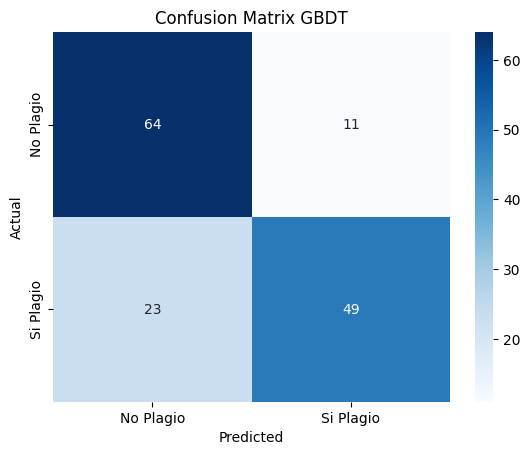

Accuracy GBDT: 0.7687074829931972
Classification Report GBDT:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79        75
           1       0.82      0.68      0.74        72

    accuracy                           0.77       147
   macro avg       0.78      0.77      0.77       147
weighted avg       0.78      0.77      0.77       147

Confusion Matrix Combined:
 [[72  3]
 [34 38]]


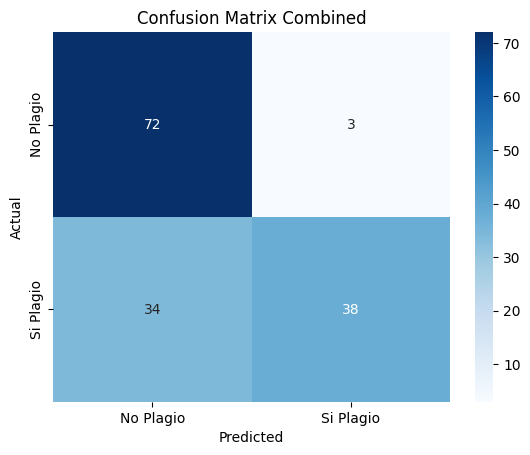

Accuracy Combined: 0.7482993197278912
Classification Report Combined:
               precision    recall  f1-score   support

           0       0.68      0.96      0.80        75
           1       0.93      0.53      0.67        72

    accuracy                           0.75       147
   macro avg       0.80      0.74      0.73       147
weighted avg       0.80      0.75      0.74       147



In [23]:
from sklearn.ensemble import GradientBoostingClassifier

# Crear y entrenar el modelo GBDT
gbdt_classifier = GradientBoostingClassifier()
gbdt_classifier.fit(features_train_concatenated, labels_train)

# Realizar predicciones con el modelo GBDT
labels_prediction_gbdt = gbdt_classifier.predict(features_test_concatenated)

# Evaluar el modelo GBDT
cm_gbdt = confusion_matrix(labels_test, labels_prediction_gbdt)
print('Confusion Matrix GBDT:\n', cm_gbdt)

# Crear una matriz de confusión para GBDT
sns.heatmap(cm_gbdt, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix GBDT')
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

# Calcular la precisión del modelo GBDT
accuracy_gbdt = accuracy_score(labels_test, labels_prediction_gbdt)
print("Accuracy GBDT:", accuracy_gbdt)

# Generar el informe de clasificación para GBDT
cr_gbdt = classification_report(labels_test, labels_prediction_gbdt)
print('Classification Report GBDT:\n', cr_gbdt)

# Promediar los resultados de ambos modelos
labels_prediction_combined = (labels_prediction + labels_prediction_gbdt) / 2
labels_prediction_combined = np.round(labels_prediction_combined)

# Evaluar el modelo combinado
cm_combined = confusion_matrix(labels_test, labels_prediction_combined)
print('Confusion Matrix Combined:\n', cm_combined)

# Crear una matriz de confusión para el modelo combinado
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Combined')
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

# Calcular la precisión del modelo combinado
accuracy_combined = accuracy_score(labels_test, labels_prediction_combined)
print("Accuracy Combined:", accuracy_combined)

# Generar el informe de clasificación para el modelo combinado
cr_combined = classification_report(labels_test, labels_prediction_combined)
print('Classification Report Combined:\n', cr_combined)

In [29]:
import joblib

# Save the model
joblib.dump(clasificador, 'random_forest_model_joined.pkl')

['random_forest_model_joined.pkl']